# **Forecasting NYPD Calls**

We've done the **cleaning, processing, and data analysis**. Now, time to build some machine learning models to **forecast** future 911 calls!

In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read in csv file and store data in a dataframe
calls = pd.read_csv("NYPD_Calls_by_date.csv")

# convert dates to datetime type
calls['dates'] = pd.to_datetime(calls['dates'])

print(calls.shape)
calls

(1734, 5)


,dates,#calls,weekday,day,month
0,2018-01-01,16007,0,1,1
1,2018-01-02,16324,1,2,1
2,2018-01-03,16980,2,3,1
3,2018-01-04,14831,3,4,1
4,2018-01-05,17251,4,5,1
...,...,...,...,...,...
1729,2022-09-26,19630,0,26,9
1730,2022-09-27,20609,1,27,9
1731,2022-09-28,21410,2,28,9
1732,2022-09-29,20929,3,29,9


In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    1734 non-null   datetime64[ns]
 1   #calls   1734 non-null   int64         
 2   weekday  1734 non-null   int64         
 3   day      1734 non-null   int64         
 4   month    1734 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 67.9 KB


Text(0.5, 1.0, '# of NYPD Calls from 2018-2022')

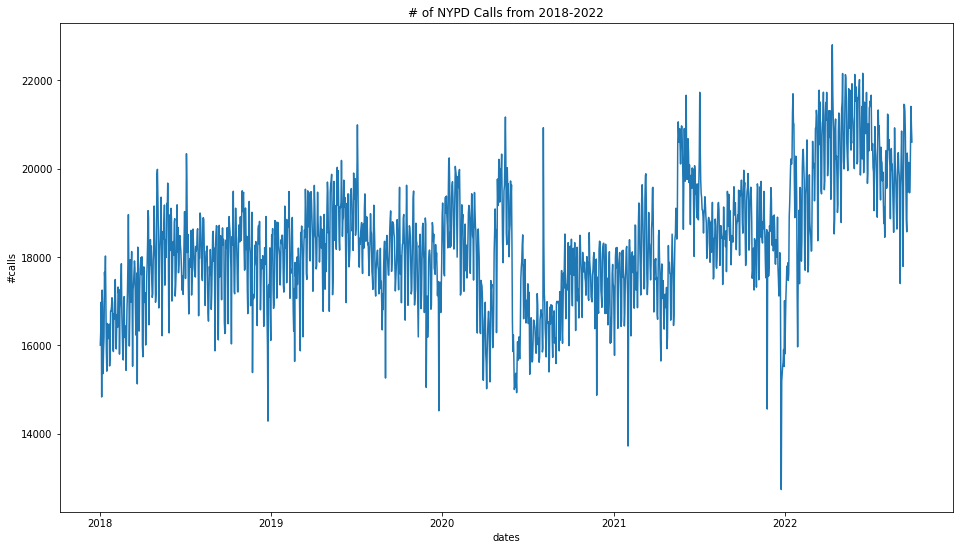

In [4]:
# check our data
plt.figure(figsize = (16, 9))
sns.lineplot(data = calls, x = 'dates', y = '#calls')
plt.title("# of NYPD Calls from 2018-2022")

## **1. Feature Engineering**

Before we start building our **forecasting models**, let's do some **feature engineering** to get variables we can use for prediction. Previously, we saw that the number of calls in previous days had some **autocorrelation**with the number of calls we receive today. Let's use the calls from the past $28$ days as features.

In addition, let's try using a **weighted rolling average** of the ***# of calls*** in the past week as another feature (not including calls from the current day in our calculation).

In [5]:
# get lags for previous 28 days
for i in range(1, 29, 1):
  calls['lag_{num}'.format(num = i)] = calls['#calls'].shift(i)

# get weighted rolling average for past 7 days
weights = np.array([(i / 28) for i in range(1, 8, 1)])
WMA = calls['#calls'].rolling(7).apply(lambda x: np.sum(weights * x)).shift(1)
calls.insert(loc = 2, column = 'WMA', value = WMA)

calls.reset_index(inplace = True, drop = True)
calls

,dates,#calls,WMA,weekday,day,month,lag_1,lag_2,lag_3,lag_4,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
0,2018-01-01,16007,NaN,0,1,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,16324,NaN,1,2,1,16007.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,16980,NaN,2,3,1,16324.0,16007.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,14831,NaN,3,4,1,16980.0,16324.0,16007.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,17251,NaN,4,5,1,14831.0,16980.0,16324.0,16007.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1729,2022-09-26,19630,19714.607143,0,26,9,19454.0,19718.0,20141.0,19473.0,...,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0,19813.0,18633.0
1730,2022-09-27,20609,19708.071429,1,27,9,19630.0,19454.0,19718.0,20141.0,...,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0,19813.0
1731,2022-09-28,21410,19908.464286,2,28,9,20609.0,19630.0,19454.0,19718.0,...,19988.0,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0
1732,2022-09-29,20929,20299.964286,3,29,9,21410.0,20609.0,19630.0,19454.0,...,19625.0,19988.0,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0


In [6]:
calls.dropna(inplace = True)
calls.reset_index(inplace = True, drop = True)
calls

,dates,#calls,WMA,weekday,day,month,lag_1,lag_2,lag_3,lag_4,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28
0,2018-01-29,15860,16641.928571,0,29,1,15931.0,16980.0,17078.0,16886.0,...,17655.0,16177.0,15895.0,15360.0,16841.0,17251.0,14831.0,16980.0,16324.0,16007.0
1,2018-01-30,16713,16456.857143,1,30,1,15860.0,15931.0,16980.0,17078.0,...,17450.0,17655.0,16177.0,15895.0,15360.0,16841.0,17251.0,14831.0,16980.0,16324.0
2,2018-01-31,16600,16482.285714,2,31,1,16713.0,15860.0,15931.0,16980.0,...,18023.0,17450.0,17655.0,16177.0,15895.0,15360.0,16841.0,17251.0,14831.0,16980.0
3,2018-02-01,17121,16481.571429,3,1,2,16600.0,16713.0,15860.0,15931.0,...,17035.0,18023.0,17450.0,17655.0,16177.0,15895.0,15360.0,16841.0,17251.0,14831.0
4,2018-02-02,17491,16617.250000,4,2,2,17121.0,16600.0,16713.0,15860.0,...,15877.0,17035.0,18023.0,17450.0,17655.0,16177.0,15895.0,15360.0,16841.0,17251.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,2022-09-26,19630,19714.607143,0,26,9,19454.0,19718.0,20141.0,19473.0,...,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0,19813.0,18633.0
1702,2022-09-27,20609,19708.071429,1,27,9,19630.0,19454.0,19718.0,20141.0,...,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0,19813.0
1703,2022-09-28,21410,19908.464286,2,28,9,20609.0,19630.0,19454.0,19718.0,...,19988.0,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0,20330.0
1704,2022-09-29,20929,20299.964286,3,29,9,21410.0,20609.0,19630.0,19454.0,...,19625.0,19988.0,20852.0,20262.0,19576.0,17400.0,18501.0,19831.0,19974.0,20364.0


Text(0.5, 1.0, '# of NYPD Calls from 2018-2022')

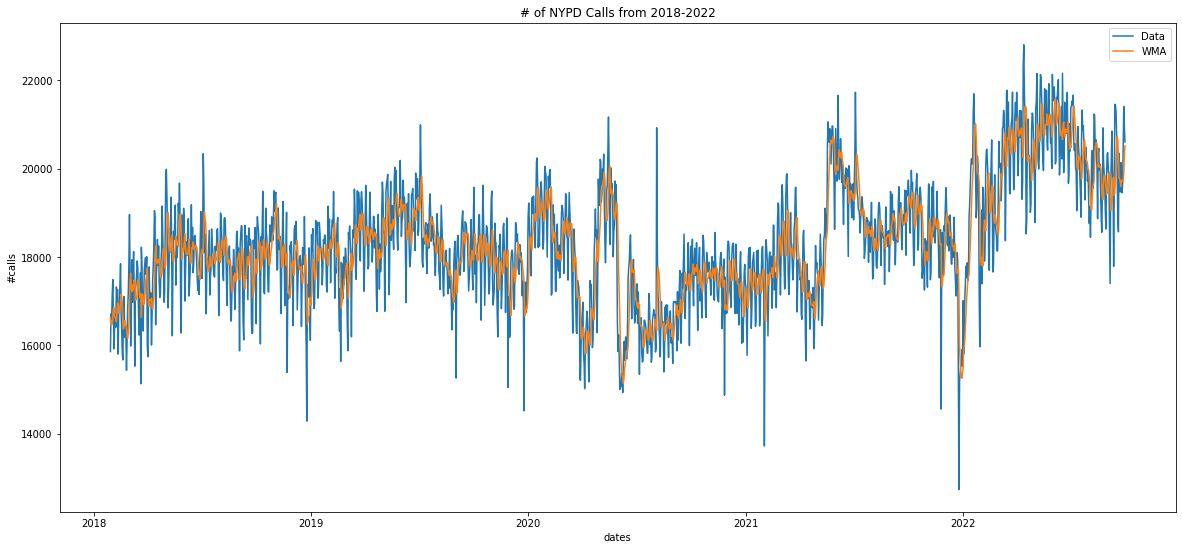

In [7]:
# check our data
plt.figure(figsize = (20, 9))
sns.lineplot(data = calls, x = 'dates', y = '#calls', label = "Data")
sns.lineplot(data = calls, x = 'dates', y = 'WMA', label = "WMA")
plt.title("# of NYPD Calls from 2018-2022")

## **2. Forecasting Models**

### **2.1 Training and Testing Data**

First, let's split our data into training and testing sets. We'll save the data from $2022$ onwards as testing data and use the previous $4$ years of data to train our models.

X_train shape (1433, 32)
X_test shape (273, 32)
y_train shape (1433,)
y_test shape (273,)


Text(0.5, 1.0, '# of NYPD Calls from 2018-2022')

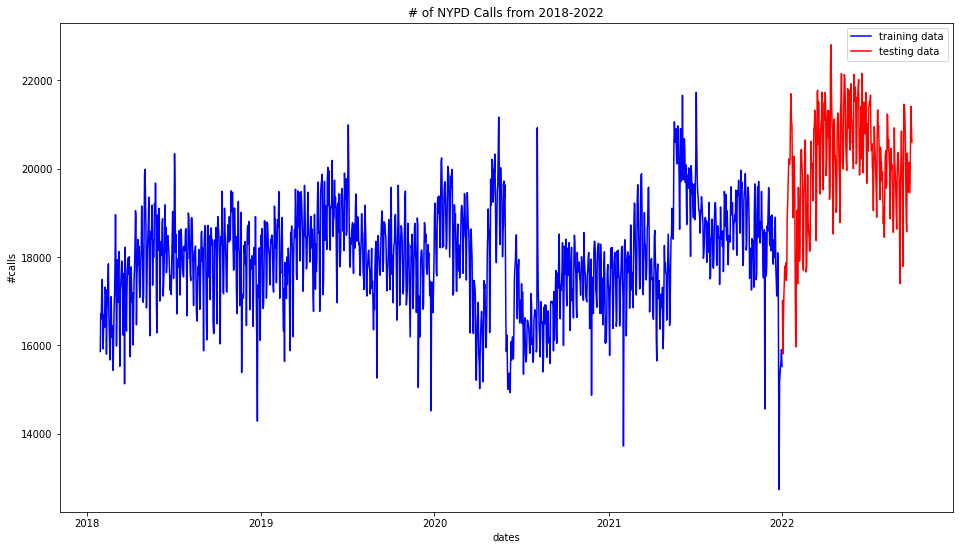

In [8]:
# split data into dates before and after 2022 for training
# and testing respectively
df_train = calls[calls['dates'] < pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
df_test = calls[calls['dates'] >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]

# remove columns that will not be used as features, and separate the
# independent variables
X_train = df_train[[col for col in df_train.columns if col not in ['dates', '#calls']]]
y_train = df_train['#calls']
X_test = df_test[[col for col in df_test.columns if col not in ['dates', '#calls']]]
y_test = df_test['#calls']

# get dimensions of training and testing data
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

# visualize our training and testing data
plt.figure(figsize = (16, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
plt.title("# of NYPD Calls from 2018-2022")

### **2.2 Baseline for models**

Note that while we'll first build models to predict the number of calls one day at a time, a more realistic model should be able to predict the volume of calls for more future dates, so that demands can be met in advance. Keeping this in mind, ***we'll build models that make predictions daily and move forward to versions that predict an entire week in advance***.

#### **2.2.1 Daily Predictions**

For a **baseline model**, let's use a model that just ***predicts that the number of calls tomorrow is going to be the same as the number of calls received today***.

In [9]:
# use mean absolute percentage error as our error metric
from sklearn.metrics import mean_absolute_percentage_error as mape

# use previous days # of calls as a proxy for # of calls today
y_pred = X_test['lag_1']

print("MAPE for Daily Baseline: " + str(mape(y_test, y_pred)))

MAPE for Daily Baseline: 0.03491303317131199


Text(0.5, 1.0, 'Daily Baseline Model')

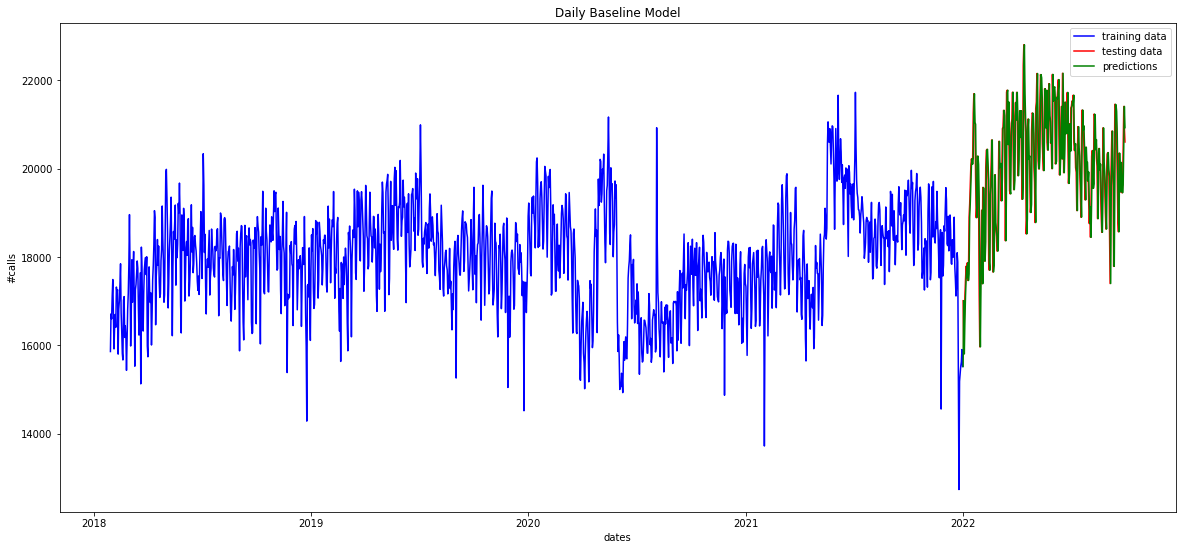

In [10]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Baseline Model")

Text(0.5, 1.0, 'Daily Baseline Model')

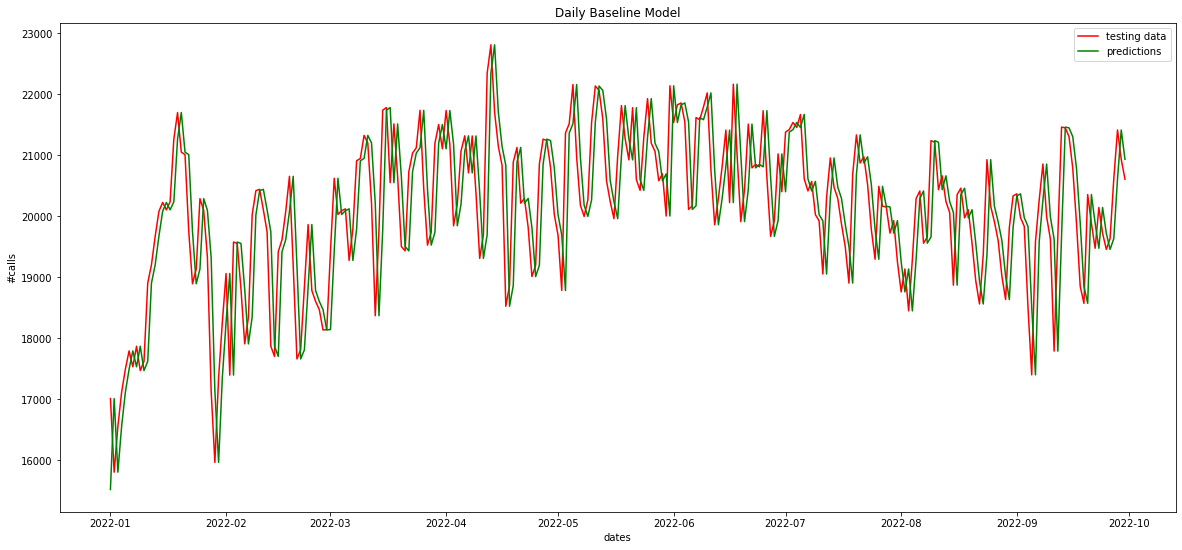

In [11]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Baseline Model")

#### **2.2.2 Weekly Predictions**

For our **weekly baseline model**, let's use a model that predicts that the number of calls in the following week is the same as the number of calls received today.

In [12]:
y_pred = y_test.copy()
y_pred = y_pred.reset_index(drop = True)

y_pred[y_pred.index%7 == 0] = y_pred.shift(1)[y_pred.index%7 == 0]
y_pred[y_pred.index % 7 != 0] = np.nan
y_pred.loc[0] = y_train.reset_index(drop = True).loc[len(y_train)-1]
y_pred.ffill(inplace = True)

print("MAPE for Weekly Baseline Model: " + str(mape(y_test, y_pred)))

MAPE for Weekly Baseline Model: 0.04742840154692944


Text(0.5, 1.0, 'Weekly Baseline Model')

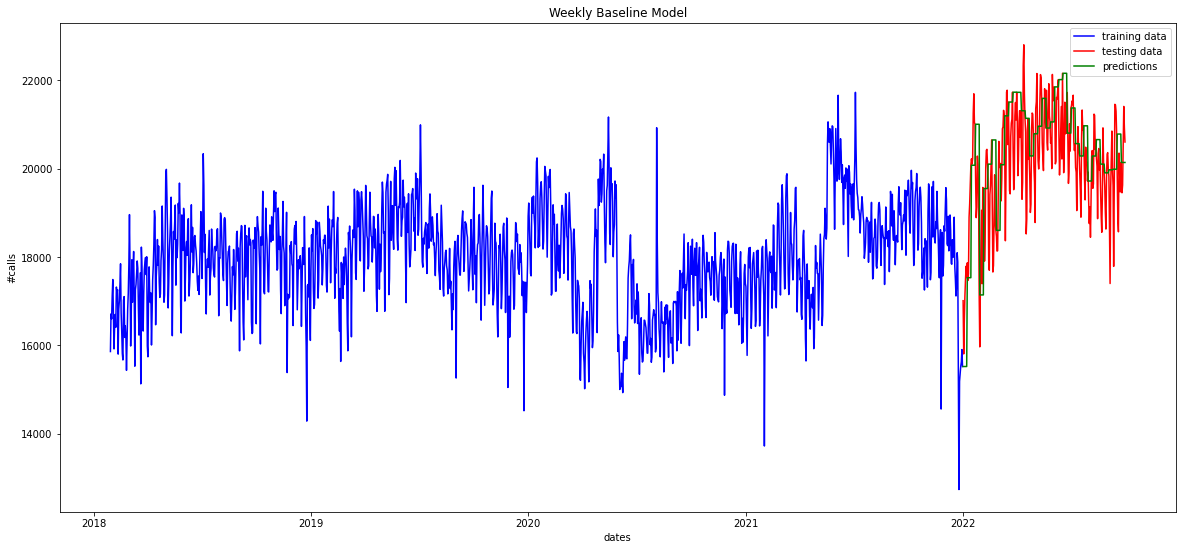

In [13]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = np.array(y_pred), color = 'green', label = "predictions")
plt.title("Weekly Baseline Model")

Text(0.5, 1.0, 'Weekly Baseline Model')

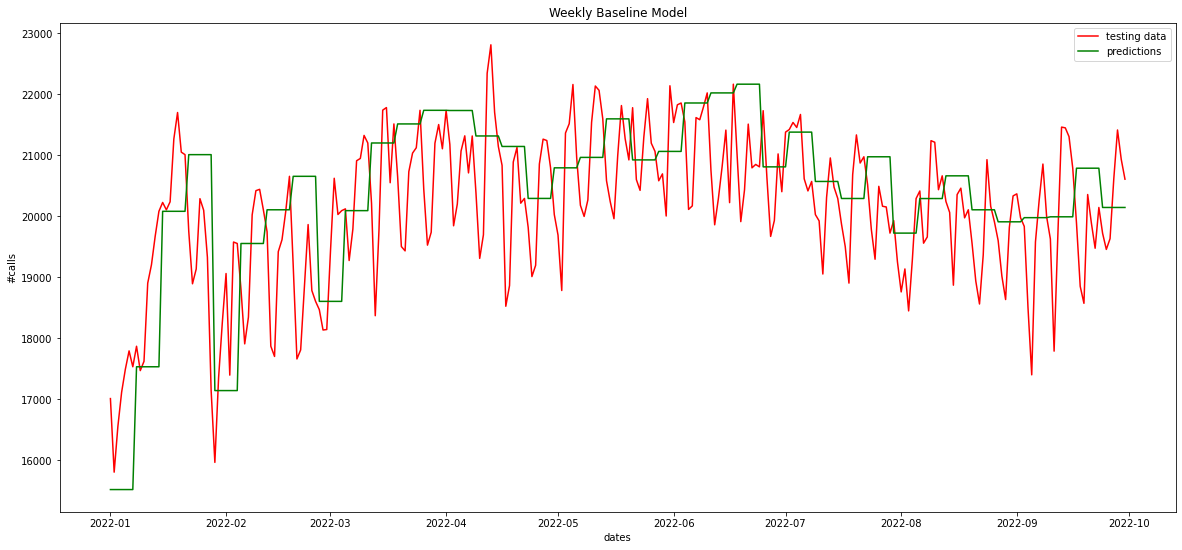

In [14]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = np.array(y_pred), color = 'green', label = "predictions")
plt.title("Weekly Baseline Model")

### **2.3 Linear Regression**

#### **2.3.1 Daily Predictions**

Let's train a **linear regression** model to make daily predictions, given complete data for each new day.

In [15]:
from sklearn.linear_model import LinearRegression

# define model
lr = LinearRegression()

# fit on training data
lr.fit(X_train.values, y_train)

# predict on test data
y_pred = lr.predict(X_test)

print("MAPE for Daily Linear Regression: " + str(mape(y_test, y_pred)))

MAPE for Daily Linear Regression: 0.026127065823502448


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Text(0.5, 1.0, 'Daily Linear Regression')

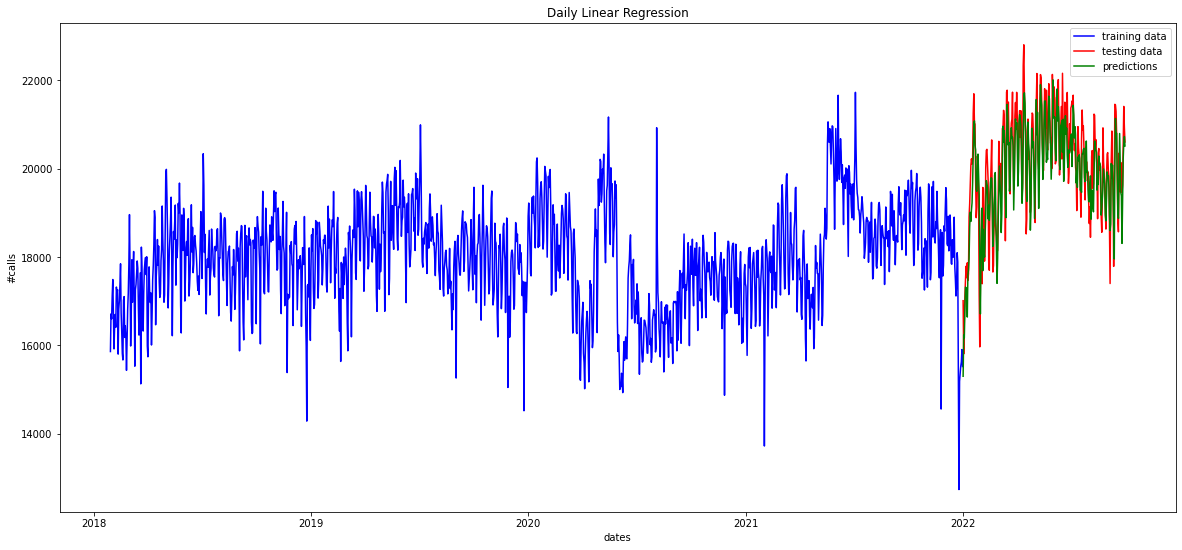

In [16]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Linear Regression")

Text(0.5, 1.0, 'Daily Linear Regression')

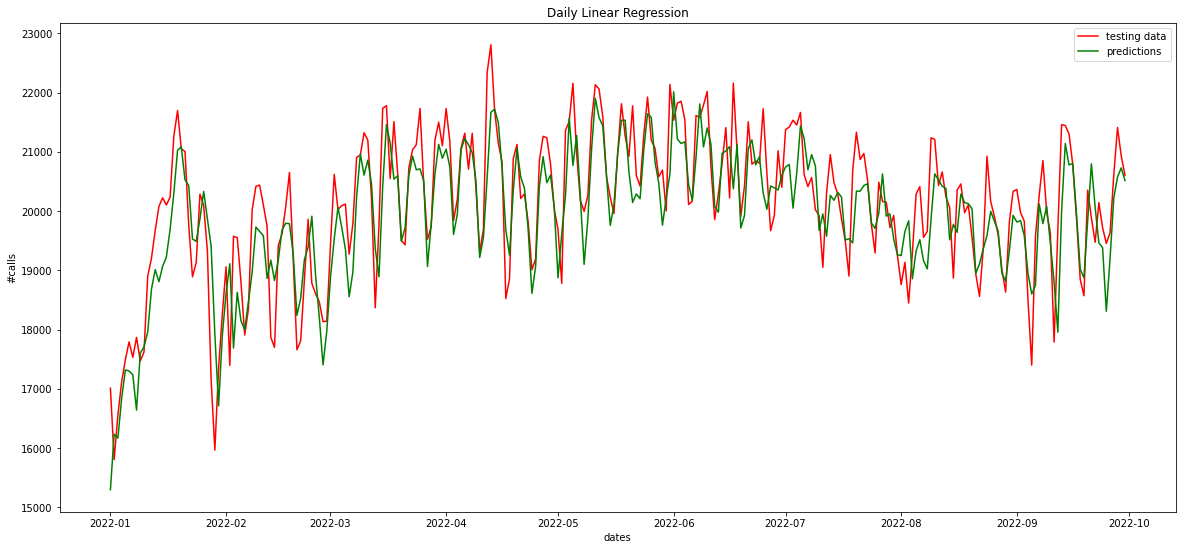

In [17]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Linear Regression")

Looks like our **daily linear regression model** is fitting our data very well. This may be because we're using the **weighted moving average** of the past week as a feature. To make sure, let's check the **coefficients** of our linear model.

    feature  feature_importance
0       WMA        2.661397e+12
4     lag_1        6.653492e+11
5     lag_2        5.702993e+11
6     lag_3        4.752494e+11
7     lag_4        3.801995e+11
8     lag_5        2.851497e+11
9     lag_6        1.900998e+11
10    lag_7        9.504989e+10
1   weekday        4.138733e+01
3     month        8.377161e+00
2       day        2.092059e+00
17   lag_14        1.766968e-01
19   lag_16        1.015930e-01
24   lag_21        9.371948e-02
12    lag_9        8.208487e-02
31   lag_28        6.943512e-02
22   lag_19        6.639099e-02
14   lag_11        6.610199e-02
18   lag_15        5.513000e-02
23   lag_20        3.948975e-02
29   lag_26        3.694153e-02
27   lag_24        3.588867e-02
25   lag_22        2.874756e-02
30   lag_27        2.507019e-02
13   lag_10        2.488554e-02
26   lag_23        2.082825e-02
11    lag_8        2.079700e-02
16   lag_13        2.076882e-02
28   lag_25        2.059937e-02
21   lag_18        8.041382e-03
20   lag

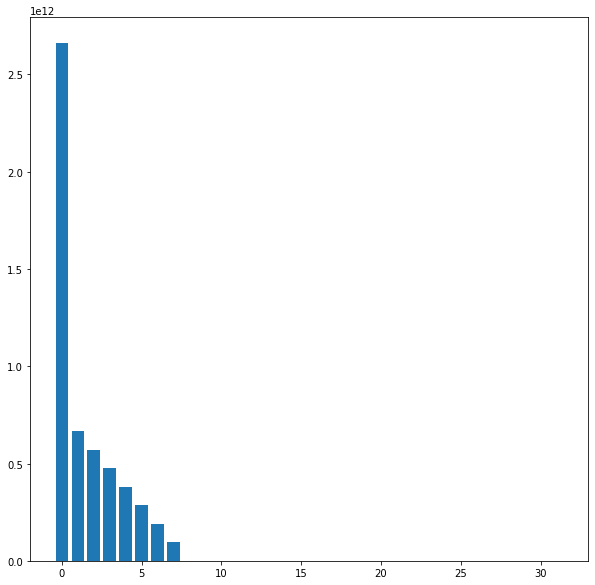

In [18]:
# get importance
importance = lr.coef_

# get feature importances and order them
feature_importance = pd.DataFrame({'feature':X_train.columns, 'feature_importance':[abs(i) for i in importance]})
print(feature_importance.sort_values('feature_importance',ascending=False))

# plot feature importance
plt.figure(figsize = (10, 10))
plt.bar([x for x in range(len(importance))], sorted([abs(i) for i in importance], reverse = True))
plt.show()

As expected, our **WMA (lagged by a day)** is extremely important in helping predict future call volumes.

#### **2.3.2 Recursive Weekly Predictions**

Since our model is performing well for day-to-day predictions, let's check whether it's capapble of making good predictions for the **entire week in advance**. We'll use a **recursive weekly model**, where we use our **daily linear regression model** to ***predict the number of calls for the first day***. Then, ***using our predictions for the first day as features, we'll predict the number of calls in the second day***. We can repeat this procedure to get predictions for the entire week, then start all over again for the next week.

We might expect that since we are ***making predictions using predicted data as features***, there will be more considerable errors by our model.



In [19]:
# we start with the month of December 2021 to start making predictions
# for January 2022 and so on
y_pred_weekly = df_train[df_train['dates'] < pd.to_datetime("2022-01-01", format='%Y-%m-%d')].copy()
y_pred_weekly = y_pred_weekly[y_pred_weekly['dates'] >= pd.to_datetime("2021-12-01", format='%Y-%m-%d')]
y_pred_weekly.reset_index(drop=True, inplace=True)

# add dates to predict on
y_pred_weekly = y_pred_weekly.append(df_test.copy(), ignore_index = True)
y_pred_weekly.insert(loc = 1, column = '#actual_calls', value = y_pred_weekly['#calls'])

# make weekly predictions, using our predicted values to make new
# predictions on later days of the week
for ind in range(31, len(y_pred_weekly), 7):
  for i in range(ind, min(ind + 7, len(y_pred_weekly)), 1):
    # predict # of calls in a day
    y_pred_weekly.loc[i, '#calls'] = lr.predict(np.array(y_pred_weekly.iloc[i, 3:]).reshape(1, -1))[0]

    # update lags, using known and predicted # of calls in previous days
    for j in range(1, 29, 1):
      y_pred_weekly['lag_{num}'.format(num = j)] = y_pred_weekly['#calls'].shift(j)

    # update weighted rolling average with known and predicted number of calls
    y_pred_weekly['WMA'] = y_pred_weekly['#calls'].rolling(7).apply(lambda x: np.sum(weights * x)).shift(1)

  # at the end of each week, update lags with acutal # of calls since
  # we now know these values
  for i in range(1, 29, 1):
      y_pred_weekly['lag_{num}'.format(num = i)] = y_pred_weekly['#actual_calls'].shift(i)

  # at the end of each week, update WMA with known call volumes for the previous
  # week
  y_pred_weekly['WMA'] = y_pred_weekly['#actual_calls'].rolling(7).apply(lambda x: np.sum(weights * x)).shift(1)

# get our weekly predictions
y_pred = np.array(y_pred_weekly.loc[31:, '#calls'])

print("MAPE for Recursive Weekly Linear Regression: " + str(mape(y_test, y_pred)))

MAPE for Recursive Weekly Linear Regression: 0.06301978906798464


Text(0.5, 1.0, 'Recursive Weekly Linear Regression')

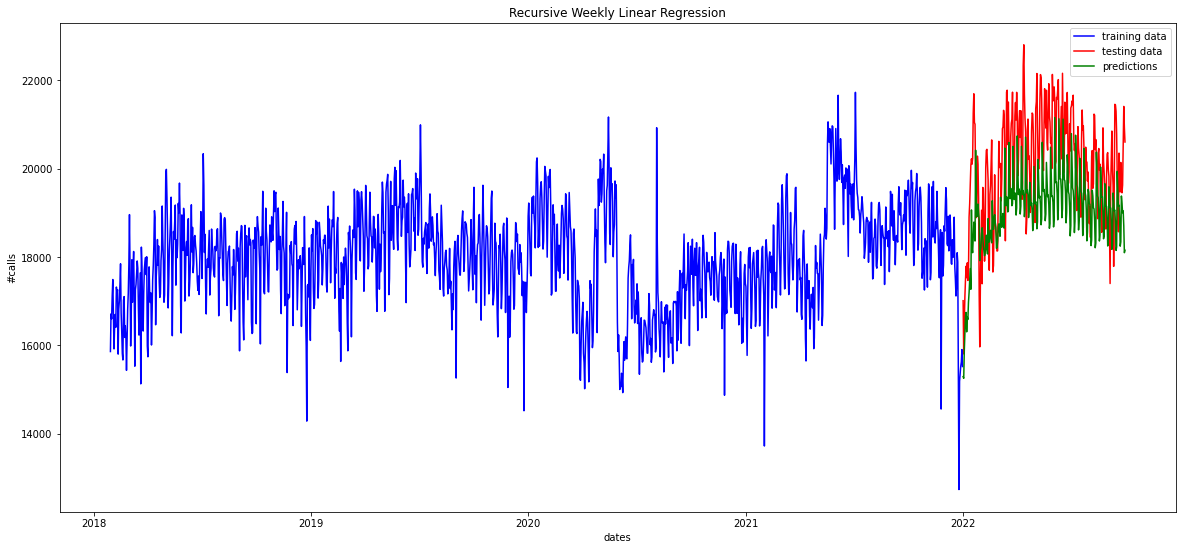

In [20]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Recursive Weekly Linear Regression")

Text(0.5, 1.0, 'Recursive Weekly Linear Regression')

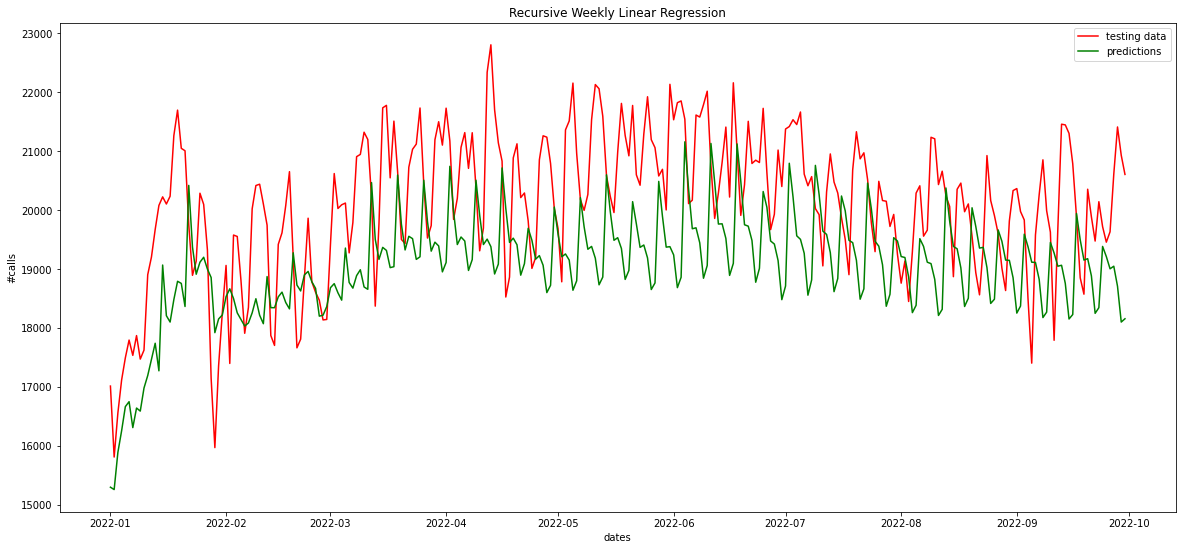

In [21]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Recursive Weekly Linear Regression")

As expected, our ***model performs worse when recursively predicting call volumes a week in advance***. In fact, our **Mean Absolute Percentage Error (MAPE)** is $0.0630$, which is much higher than our **weekly baseline model**'s MAPE of $0.0474$.

#### **2.3.3 Direct Weekly Linear Regression**

***Instead of making predictions on predicted call volumes***, let's try ***building a linear regression model that predicts the number of calls across the entire week given data about the previous month***.

We'll have to **reshape our training and testing data** so that our linear model can make **multi-step predictions**.

In [22]:
# helpful function to flatten our features to a more usuable format
def flatten(l):
    return [item for sublist in l for item in sublist]
    
# get number of calls, per week
y_train_weekly = np.array([list(y_train)[i:i+7] for i in range(0, len(y_train)-6, 1)])
y_test_weekly = np.array([list(y_test)[i:i+7] for i in range(0, len(y_test)-6, 1)])

# drop final week's features since we will not be using them 
X_train_weekly = X_train.reset_index(drop=True).iloc[:-6, :]
X_test_weekly = X_test.reset_index(drop=True).iloc[:-6, :]

In [23]:
# define model
lr_week = LinearRegression()

# fit on training data
lr_week.fit(X_train_weekly, y_train_weekly)

# predict on test data
y_pred = lr_week.predict(X_test_weekly)

print("MAPE for Direct Weekly Linear Regression: " + str(mape(y_test_weekly, y_pred)))
print("MAPE for Direct Weekly Linear Regression: " + str(mape(y_test, flatten([y_pred[i] for i in range(0, len(y_pred), 7)]))))

MAPE for Direct Weekly Linear Regression: 0.03713843210275676
MAPE for Direct Weekly Linear Regression: 0.0372722362468929


Text(0.5, 1.0, 'Direct Weekly Linear Regression')

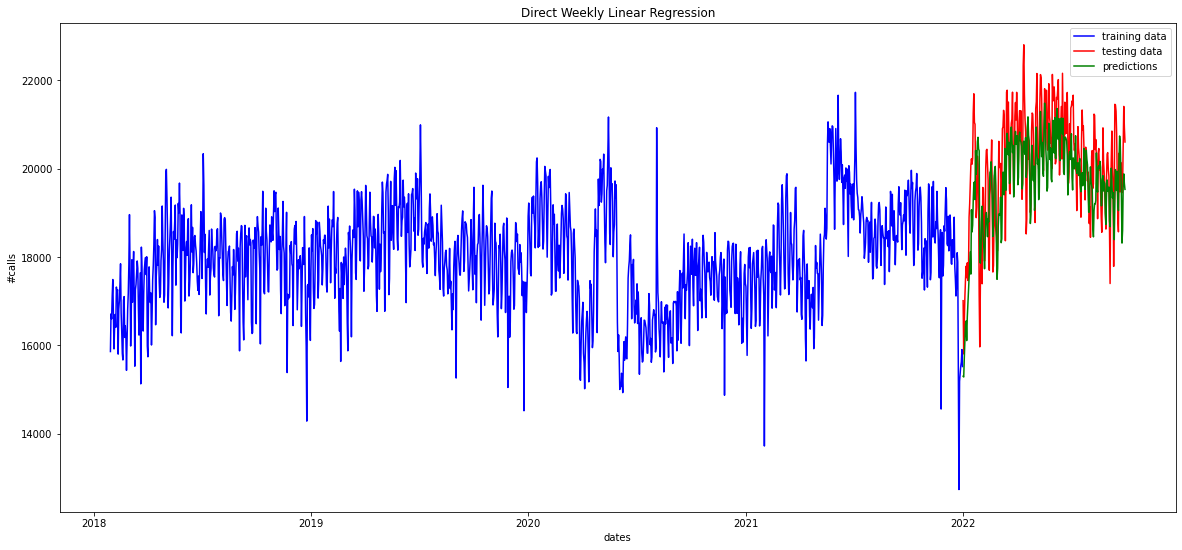

In [24]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = flatten([y_pred[i] for i in range(0, len(y_pred), 7)]), color = 'green', label = "predictions")
plt.title("Direct Weekly Linear Regression")

Text(0.5, 1.0, 'Direct Weekly Linear Regression')

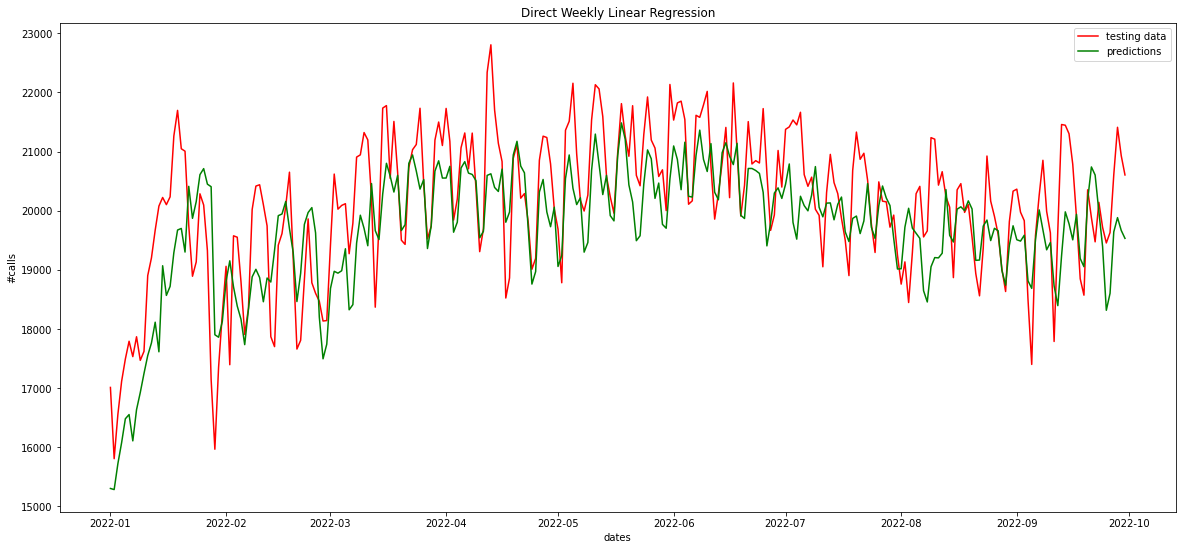

In [25]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = flatten([y_pred[i] for i in range(0, len(y_pred), 7)]), color = 'green', label = "predictions")
plt.title("Direct Weekly Linear Regression")

Our **direct weekly linear regression** model is performing a lot better than both the **recursive weekly linear** model and the **weekly baseline model**, with a **MAPE** of $0.0372$

### **2.4 Random Forest Regression**

#### **2.4.1 Daily Predictions**

Next, let's test a **random forest regression** model with ***making daily predictions.***

In [26]:
from sklearn.ensemble import RandomForestRegressor
 
# define the model
rf = RandomForestRegressor(random_state = 2022)

# fit model on training data
rf.fit(X_train, y_train)

# predict on testing data
y_pred = rf.predict(X_test)

print("MAPE for Daily Random Forest Regression: " + str(mape(y_test, y_pred)))

MAPE for Daily Random Forest Regression: 0.03679515520241429


Text(0.5, 1.0, 'Daily Random Forest Regression')

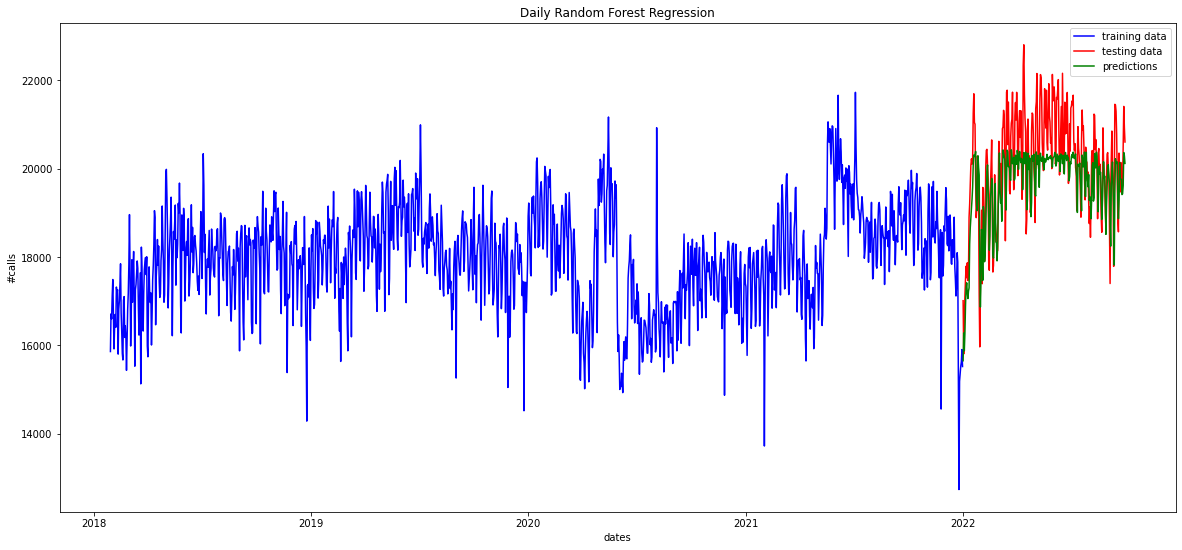

In [27]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Random Forest Regression")

Text(0.5, 1.0, 'Daily Random Forest Regression')

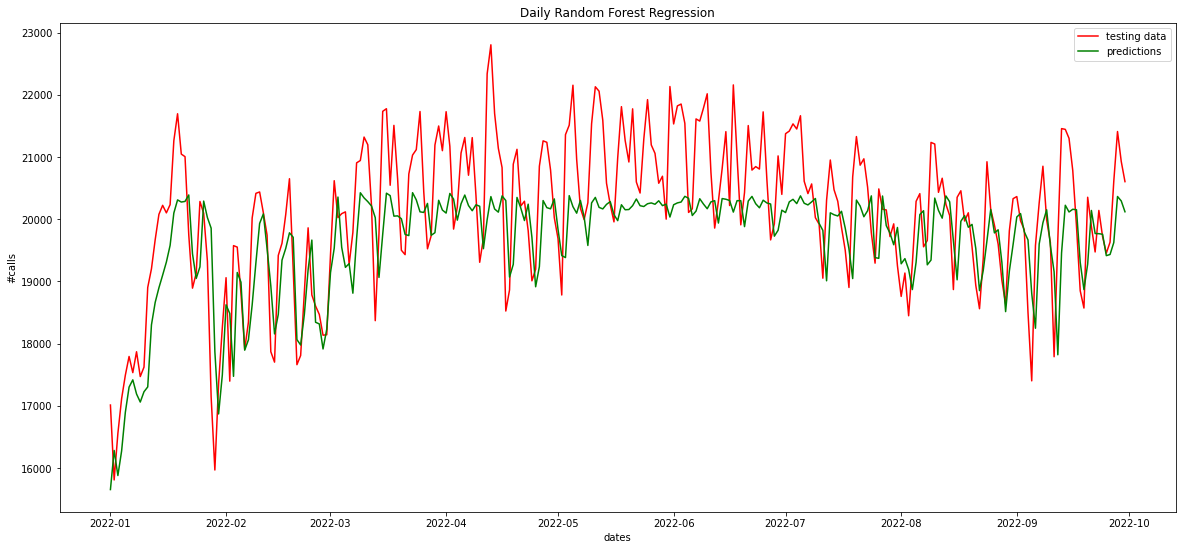

In [28]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Random Forest Regression")

Our **random forest model** doesn't seem to capture the data that well, and ***performs worse than our daily baseline model*** with its **MAPE** of $0.0368$. Since it's already ***underperforming with daily predictions, it's unlikely to do any better with weekly predictions so we'll move on to another model***.

### **2.5 XGBoost Regrssion**

#### **2.5.1 Daily Predictions**

Let's test an **XGBoost regression model** with daily predictions.

In [29]:
from xgboost import XGBRegressor

# define XGBoost model
xgb = XGBRegressor(seed = 2022)

# fit model on training data
xgb.fit(X_train, y_train)

# make predictions on testing data
y_pred = xgb.predict(X_test)

print("MAPE for Daily XGBoost Regression: " + str(mape(y_test, y_pred)))

[01:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE for Daily XGBoost Regression: 0.0382723930739229


Text(0.5, 1.0, 'Daily XGBoost Regression')

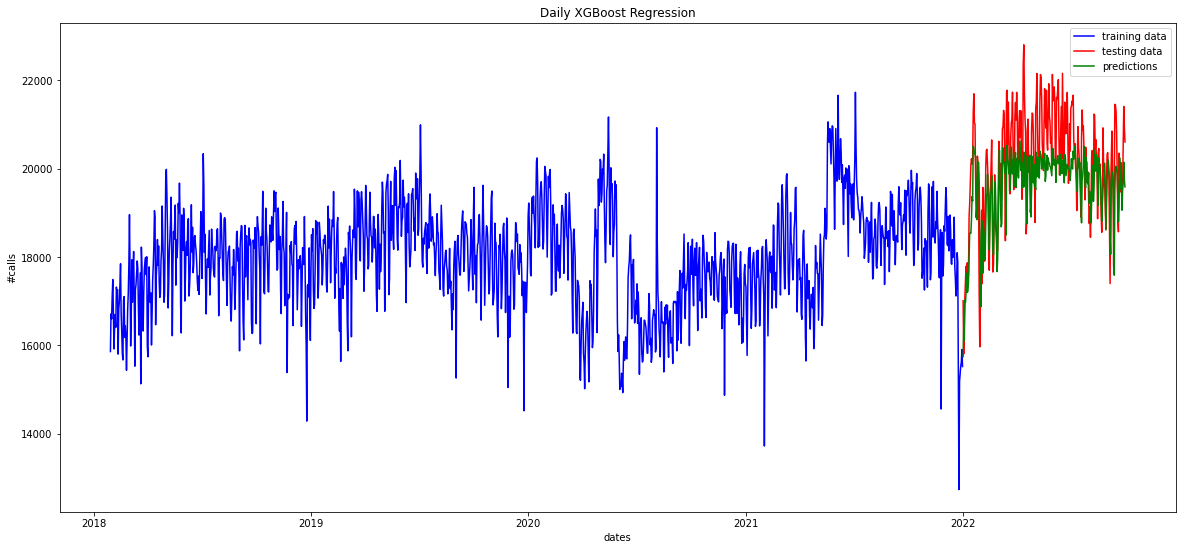

In [30]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily XGBoost Regression")

Text(0.5, 1.0, 'Daily XGBoost Regression')

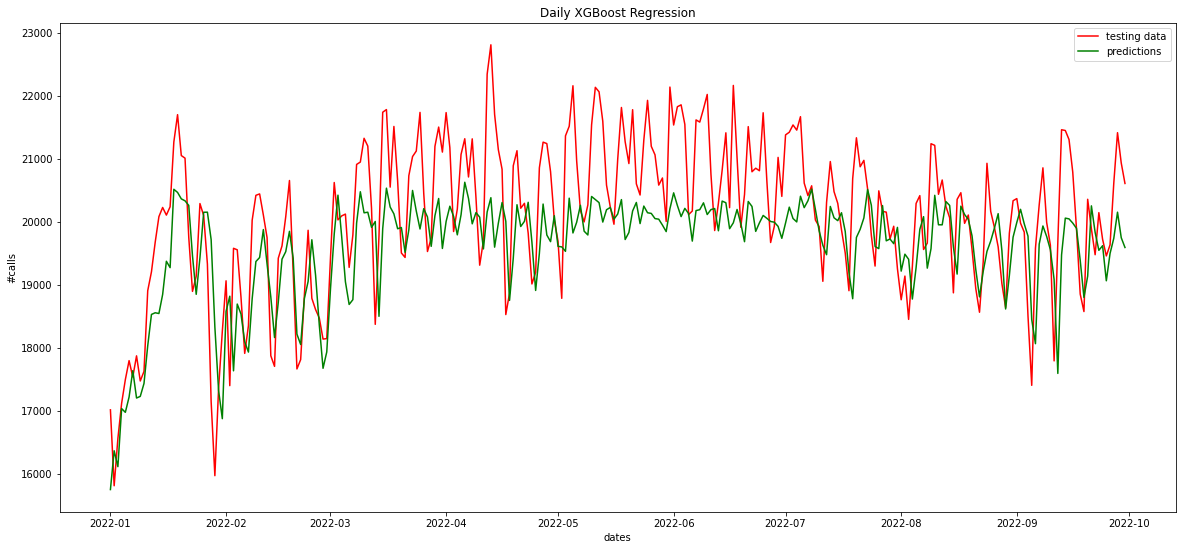

In [31]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily XGBoost Regression")

Our **XGBoost** model doesn't seem to capture the data well either,  with its **MAPE** of $0.0383$. Since ***it's already underperforming with daily predictions, it's unlikely to do any better with weekly predictions so we'll move on to another model.***

### **2.6 Neural Networks**

We've tested out some **classical machine learning models** and haven't had much luck finding any models capable of making good weekly predictions (besides our **direct weekly linear regression model**). Let's see if we'll have any more luck with **neural networks**!

#### **2.6.1 Daily Predictions**

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# fix random seed for reproducibility
tf.random.set_seed(8)

# define the keras model
model = Sequential()
model.add(Dense(28, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(Dense(56, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='linear'))

# compile the keras model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

# fit the keras model on the dataset
model.fit(X_train, y_train, epochs = 150, batch_size = 10)

Epoch 1/150
144/144 [==============================] - 1s 2ms/step - loss: 110533448.0000 - mse: 110533448.0000
Epoch 2/150
144/144 [==============================] - 0s 2ms/step - loss: 807079.1250 - mse: 807079.1250
Epoch 3/150
144/144 [==============================] - 0s 2ms/step - loss: 841856.8125 - mse: 841856.8125
Epoch 4/150
144/144 [==============================] - 0s 2ms/step - loss: 795087.3125 - mse: 795087.3125
Epoch 5/150
144/144 [==============================] - 0s 2ms/step - loss: 836500.6250 - mse: 836500.6250
Epoch 6/150
144/144 [==============================] - 0s 2ms/step - loss: 815530.4375 - mse: 815530.4375
Epoch 7/150
144/144 [==============================] - 0s 2ms/step - loss: 774116.9375 - mse: 774116.9375
Epoch 8/150
144/144 [==============================] - 0s 2ms/step - loss: 787395.8125 - mse: 787395.8125
Epoch 9/150
144/144 [==============================] - 0s 2ms/step - loss: 797899.5000 - mse: 797899.5000
Epoch 10/150
144/144 [==================

In [33]:
# evaluate the keras model
y_pred = model.predict(X_test)

# flatten output of NN model 
y_pred = flatten(y_pred)

print("MAPE for Daily Neural Network: " + str(mape(y_test, y_pred)))

9/9 [==============================] - 0s 2ms/step
MAPE for Daily Neural Network: 0.028725521221545675


Text(0.5, 1.0, 'Daily Neural Network')

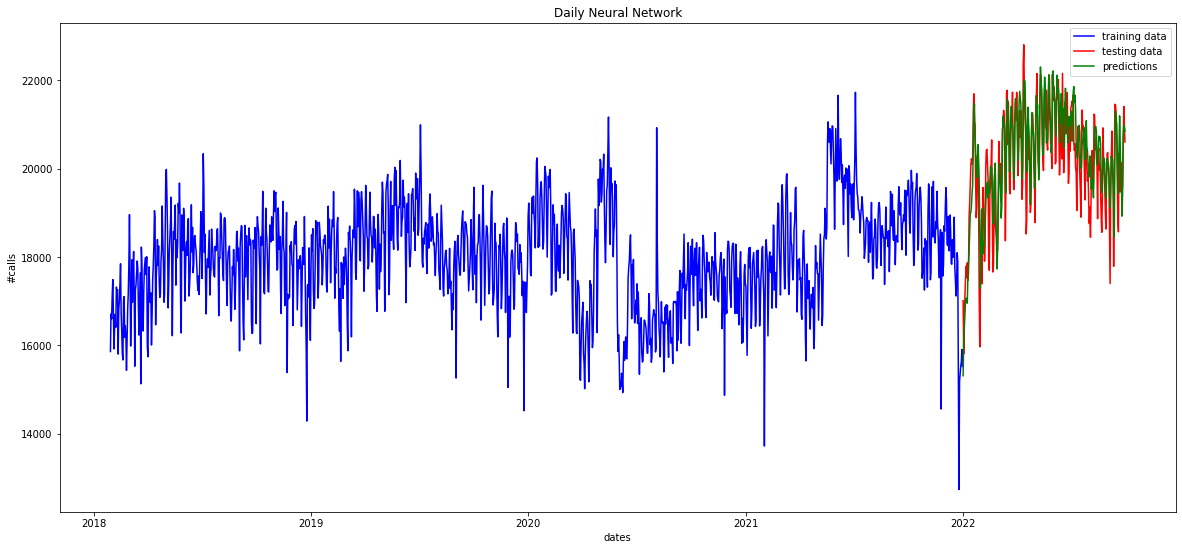

In [34]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Neural Network")

Text(0.5, 1.0, 'Daily Neural Network')

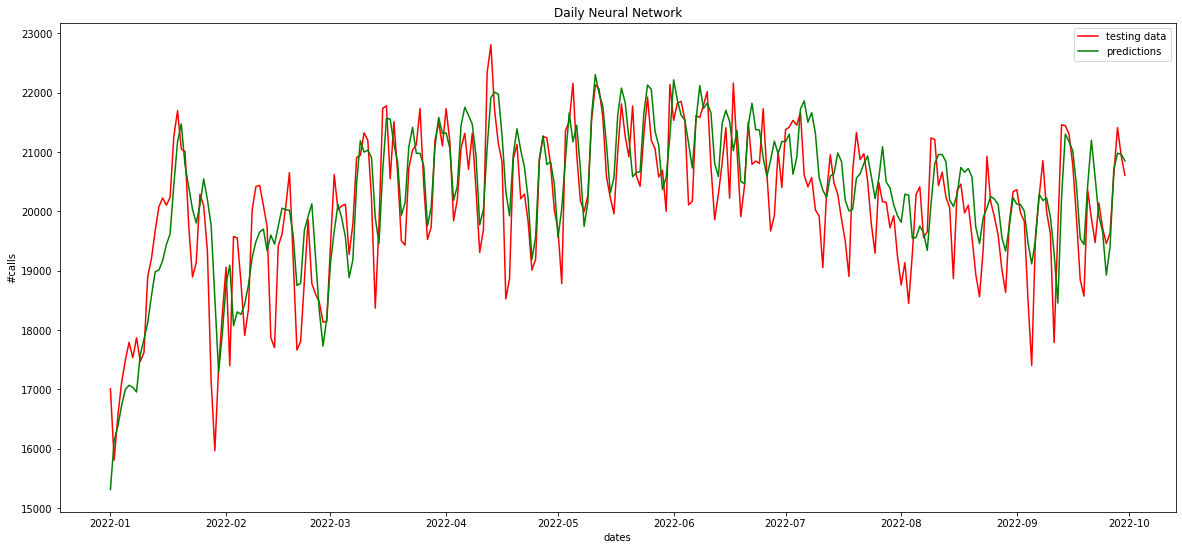

In [35]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = y_pred, color = 'green', label = "predictions")
plt.title("Daily Neural Network")

Our **neural network** performs quite well with ***daily predictions***, achieving a **MAPE** of $0.0287$, which is much ***better than our daily baseline***. This looks like a promising model, so let's try to adapt this to make weekly predictions.

#### **2.6.2 Weekly Predictions**

For our **weekly neural network**, we'll use the same reshaped training and testing data that we used for our **direct weekly linear regression model**.

In [36]:
# define the keras model
model = Sequential()
model.add(Dense(56, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(56, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(7, activation='linear'))

# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# fit the keras model on the dataset
model.fit(X_train_weekly, y_train_weekly, epochs=250, batch_size=10)

Epoch 1/250
143/143 [==============================] - 1s 3ms/step - loss: 18814248.0000 - mse: 18814250.0000
Epoch 2/250
143/143 [==============================] - 0s 3ms/step - loss: 995077.5625 - mse: 995077.5625
Epoch 3/250
143/143 [==============================] - 0s 3ms/step - loss: 1015068.8125 - mse: 1015068.8125
Epoch 4/250
143/143 [==============================] - 0s 2ms/step - loss: 1009044.6250 - mse: 1009044.6250
Epoch 5/250
143/143 [==============================] - 0s 2ms/step - loss: 1020538.4375 - mse: 1020538.4375
Epoch 6/250
143/143 [==============================] - 0s 3ms/step - loss: 953171.5000 - mse: 953171.5000
Epoch 7/250
143/143 [==============================] - 0s 3ms/step - loss: 885524.5625 - mse: 885524.5625
Epoch 8/250
143/143 [==============================] - 0s 3ms/step - loss: 928372.6250 - mse: 928372.6875
Epoch 9/250
143/143 [==============================] - 0s 3ms/step - loss: 941276.5000 - mse: 941276.5000
Epoch 10/250
143/143 [==============

In [37]:
# evaluate the keras model
y_pred = model.predict(X_test_weekly)

print("MAPE for Neural Network with Weekly Predictions (All Weeks): " + str(mape(y_test_weekly, y_pred)))
print("MAPE for Neural Network with Weekly Predictions (Week-to-Week): " + str(mape(y_test, flatten([y_pred[i] for i in range(0, len(y_pred), 7)]))))

9/9 [==============================] - 0s 2ms/step
MAPE for Neural Network with Weekly Predictions (All Weeks): 0.03511285056589699
MAPE for Neural Network with Weekly Predictions (Week-to-Week): 0.03724163705680505


Text(0.5, 1.0, 'Weekly Neural Network')

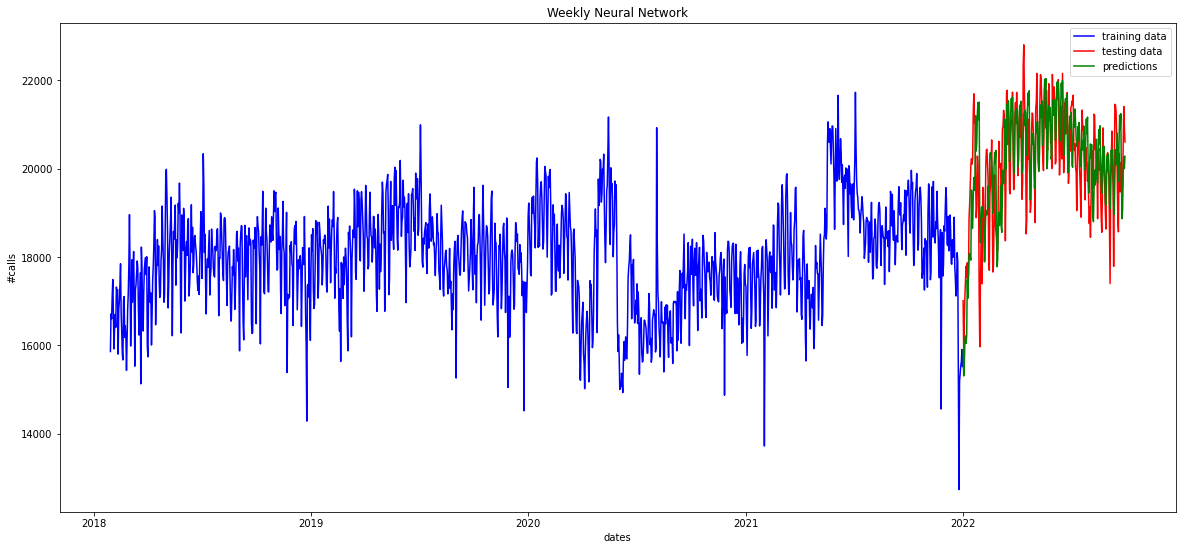

In [38]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_train, x = 'dates', y = '#calls', color = 'blue', label = "training data")
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = flatten([y_pred[i] for i in range(0, len(y_pred), 7)]), color = 'green', label = "predictions")
plt.title("Weekly Neural Network")

Text(0.5, 1.0, 'Weekly Neural Network')

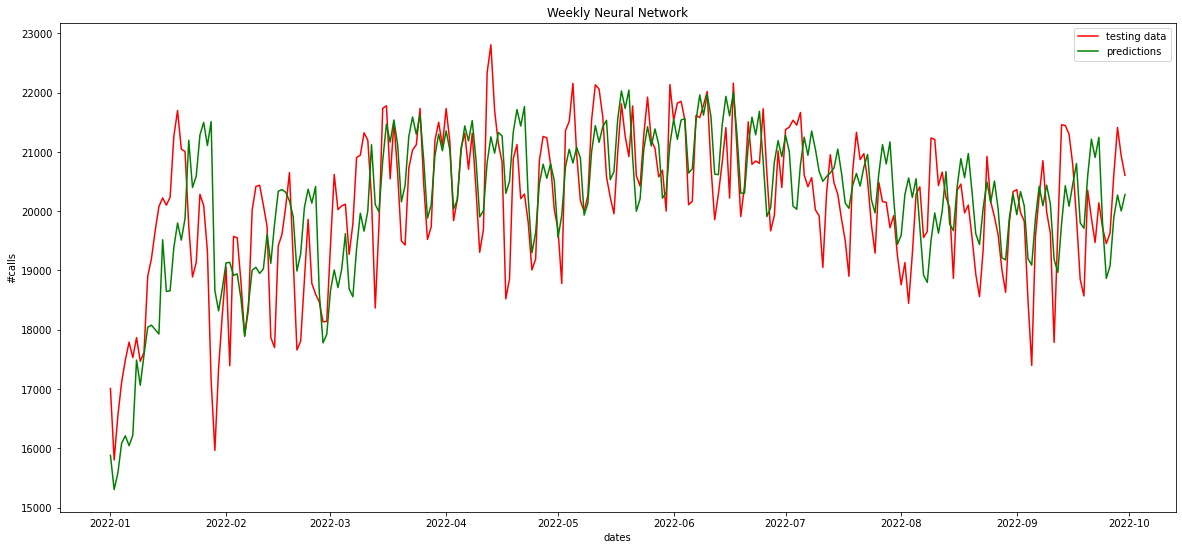

In [39]:
plt.figure(figsize = (20, 9))
sns.lineplot(data = df_test, x = 'dates', y = '#calls', color = 'red', label = "testing data")
sns.lineplot(x = df_test.dates, y = flatten([y_pred[i] for i in range(0, len(y_pred), 7)]), color = 'green', label = "predictions")
plt.title("Weekly Neural Network")

When making **daily predictions**, our **linear regression model** does exceptionably well. Our ***direct weekly linear regression and weekly neural network models perform the best with making weekly predictions***.

Further work could involve collecting more NYPD call data and utilizing more sophiticated models to carry out time series forecasting.